# Combining LSTM and GRU for Text Generator

## Importing Dependencies

In [9]:
import numpy as np
import os
import time
import re
import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt

from wordcloud import WordCloud
from PIL import Image
from datetime import datetime
from collections import Counter 
from tensorflow.data.experimental import AUTOTUNE
from tensorflow.strings import split, reduce_join
from tensorflow.keras.layers import StringLookup, Embedding, LSTM, GRU, Dense, Dropout, Bidirectional
from tensorflow.data import Dataset
from tensorflow.keras import Model
from tensorflow.keras.callbacks import Callback

## Read dataset

In [2]:
text = open('/kaggle/input/prototype-ta/680 S.txt', 'rb').read().decode(encoding='utf-8')

## Length total charachter

In [3]:
# Panjang karakter
print(f'Length of text: {len(text)} characters')

Length of text: 19172446 characters


## Unique Word

In [4]:
# Split data dan menemukan kata unik
vocab = sorted(set(text.lower().split()))
print(f'{len(vocab)} unique word')

95701 unique word


In [5]:
text = str(text).lower().split('\n')
df = pd.DataFrame(text)
df.rename(columns = {0:"Text"}, inplace=True)
df

,Text
0,untuk mendukung penelitian ini diperlukan teor...
1,website perguruan tinggi merupakan salah satu ...
2,penelitian tentang perancangan sistem informas...
3,manusia sebagai makhluk sosial tentu membutuhk...
4,belajar matematika merupakan hal dasar yang wa...
...,...
1298,"penelitian yohanes bowo widodo, tata sutabri, ..."
1299,kementerian lingkungan hidup dan kehutanan klh...
1300,kebutuhan bahan bakar minyak bbm pada kendaraa...
1301,pertumbuhan penggunaan teknologi informasi dan...


## EDA

In [6]:
text_len = []
for text in df.Text:
    tweet_len = len(text.split())
    text_len.append(tweet_len)

df['Text_len'] = text_len
df_descending = df.sort_values('Text_len', ascending=False)
df_ascending = df.sort_values('Text_len', ascending=True)

In [7]:
y_max = df_descending.Text_len.head(10).values
y_min = df_ascending.Text_len.head(10).values
x = np.arange(10)

## Visualize Top 10 Text Length

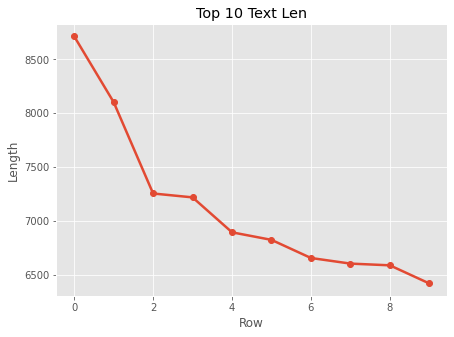

In [8]:
plt.style.use('ggplot')
plt.figure(figsize=(7,5))
plt.plot(x, y_max, marker='o', linewidth=2.5)
plt.title('Top 10 Text Len')
plt.ylabel('Length')
plt.xlabel('Row')
plt.savefig('Top.jpg')

## Visualize Bottom 10 Text Length

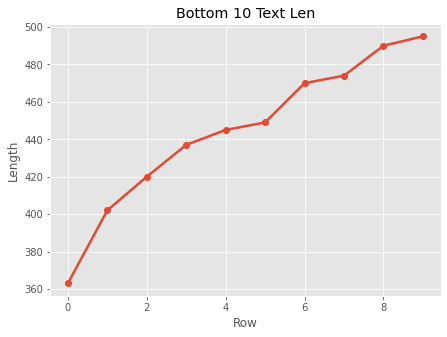

In [67]:
plt.style.use('ggplot')
plt.figure(figsize=(7,5))
plt.plot(x, y_min, marker='o', linewidth=2.5)
plt.title('Bottom 10 Text Len')
plt.ylabel('Length')
plt.xlabel('Row')
plt.savefig('Bottom.jpg')

## Visualize Most Common Word

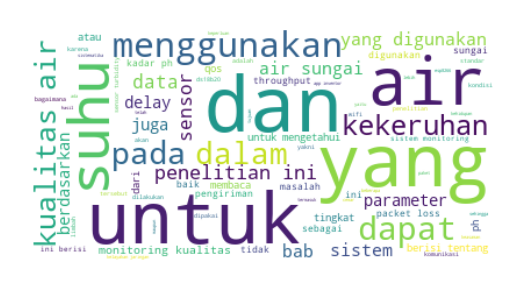

In [72]:
wordcloud = WordCloud(contour_width=1, contour_color='black', background_color='white', max_words=150).generate(text)
plt.figure(figsize=(2, 2), dpi=300)
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.savefig("wordcloud.jpg")
plt.show()

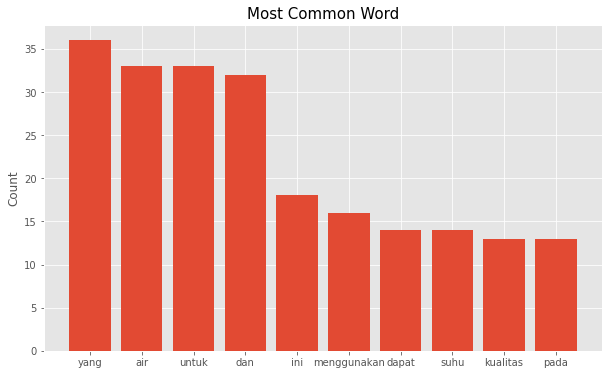

In [68]:
# Split the sentence into words
words_list = text.lower().split()

# Count the occurence of each word
word_count = Counter(words_list)

# Get the top 5 words
top_5_words = word_count.most_common(10)

# Get the labels for the x-axis
labels, values = zip(*top_5_words)

# Plot a bar graph
plt.style.use('ggplot')
plt.figure(figsize=(10,6))
plt.bar(labels, values)
plt.title('Most Common Word', fontsize=15)
plt.ylabel('Count', fontsize=12)
plt.savefig('Most Common Word.jpg')

## Preprocessing Data

In [69]:
# melakukan konversi unique words ke dalam ID
ids_from_chars = StringLookup(vocabulary=list(vocab), mask_token=None)

In [70]:
# vocabulary berfungsi untuk daftar ID yang akan dikonversi
# invert berfungsi untuk menentukan apakah string akan bisa dikonversi menjadi ID atau tidak, True => ya
# mask_token dikunakan untuk menandai ID yang tidak diketahui
chars_from_ids = StringLookup(vocabulary=ids_from_chars.get_vocabulary(), invert=True, mask_token=None)

In [71]:
# mengambil item pada 'ids' dan mengubah kedalam karakter, selanjutnya masing masing item digabungkan menggunakan
# 'reduce_join' dengan menggunakan tambahan separator spasi
# hasilnya adalah string yang terbuat dari kumpulan item 'ids'

def text_from_ids(ids):
    return reduce_join(chars_from_ids(ids), axis=-1, separator = " ")

In [72]:
# melakukan split pada dataset lalu mengkonversi menjadi unique ID
all_ids = ids_from_chars(split(text))

In [73]:
# membuat sebuah dataset dari tensor slices dari sebuah variabel yang disebut 'all_ids'. 
# tensor slices adalah sebuah fungsi yang mengambil sebuah tensor (sebuah array multi-dimensi) dan memotongnya menjadi beberapa bagian.
# cara ini, Anda dapat membuat sebuah dataset dari satu array multi-dimensi.  
# menggunakan fungsi 'from_tensor_slices', dapat membuat sebuah dataset yang berisi slice-slice dari array 'all_ids'.

ids_dataset = Dataset.from_tensor_slices(all_ids)

In [74]:
for ids in ids_dataset.take(5):
    print(chars_from_ids(ids).numpy().decode(encoding='utf-8'))

air
merupakan
kebutuhan
utama
bagi


## Tunning Training Parameter

### Pada tahap ini kita mulai melakukan tunning terhadap hyperparameter, beberapa parameter yang akan ditunning yaitu Embedding Layer, LSTM Layer, GRU Layer, Dense Layer, serta sequence_length.

In [75]:
seq_length = 5
epochs = 10
batch_size = 64
embedding_dim = 512
vocab_size = len(ids_from_chars.get_vocabulary())
buffer_size = 10000

In [76]:
# Setelah membagi seq_length, kita harus mempersiapkan target, penelitian ini membagi seq_length menjadi 3, yaitu 5, 10, 15.

# kode program untuk membagi dataset
# menjadi beberapa bagian yang disebut sebagai sequence.
# Variabel "sequences" adalah variabel yang menyimpan data hasil pembagian. 
# Variabel "ids_dataset" adalah variabel yang menyimpan dataset yang akan dibagi. 
# Variabel "seq_length" adalah variabel yang menyimpan panjang dari masing-masing sequence. 
# Parameter drop_remainder=True digunakan untuk menghapus bagian sequence yang tidak memiliki panjang yang sama dengan seq_length. Dengan demikian, setiap sequence akan memiliki panjang yang sama.

sequences = ids_dataset.batch(seq_length+1, drop_remainder=True)

In [77]:
for seq in sequences.take(5):
    print(chars_from_ids(seq).numpy())

[b'air' b'merupakan' b'kebutuhan' b'utama' b'bagi' b'proses']
[b'kehidupan' b'dibumi,' b'sehingga' b'tidak' b'ada' b'kehidupan']
[b'seandainya' b'tidak' b'ada' b'air' b'dibumi.' b'air']
[b'juga' b'dapat' b'menjadi' b'bencana' b'jika' b'tersedia']
[b'dalam' b'kondisi' b'yang' b'tidak' b'baik' b'dalam']


In [78]:
for seq in sequences.take(5):
    print(text_from_ids(seq).numpy())

b'air merupakan kebutuhan utama bagi proses'
b'kehidupan dibumi, sehingga tidak ada kehidupan'
b'seandainya tidak ada air dibumi. air'
b'juga dapat menjadi bencana jika tersedia'
b'dalam kondisi yang tidak baik dalam'


In [79]:
# Fungsi untuk melakukan split sebanyak seq_length dan seq_length + 1 untuk membagi data input dan target

def split_input_target(sequence):
    input_text = sequence[:-1]
    target_text = sequence[1:]
    return input_text, target_text

In [80]:
dataset = sequences.map(split_input_target)

In [81]:
for input_example, target_example in dataset.take(2):
    print("Input :", text_from_ids(input_example).numpy())
    print("Target:", text_from_ids(target_example).numpy())

Input : b'air merupakan kebutuhan utama bagi'
Target: b'merupakan kebutuhan utama bagi proses'
Input : b'kehidupan dibumi, sehingga tidak ada'
Target: b'dibumi, sehingga tidak ada kehidupan'


In [82]:
dataset = (
    dataset
    .shuffle(buffer_size)
    .batch(batch_size, drop_remainder=True)
    .prefetch(AUTOTUNE))
dataset

<PrefetchDataset shapes: ((64, 5), (64, 5)), types: (tf.int64, tf.int64)>

In [83]:
class MyModel(Model):
    def __init__(self, vocab_size, embedding_dim):
        super().__init__(self)
        self.embedding_layer = Embedding(vocab_size, embedding_dim)
        self.hid1_lstm = LSTM(256, return_sequences=True, return_state=True)
        self.hid2_lstm = LSTM(256, return_sequences=True, return_state=True)
        self.hid1_gru = GRU(256, return_sequences=True, return_state=True)
        self.hid2_gru = GRU(256, return_sequences=True, return_state=True)
        self.bidi = Bidirectional(self.hid2_gru)
        self.dense1 = Dense(2000)
        self.dense2 = Dense(2000)
        self.dense3 = Dense(vocab_size)
    def call(self, inputs, states1=None, states2=None, states3=None, states4=None, return_state=False, training=False):
        x = inputs
        x = self.embedding_layer(x, training=training)
        if states1 is None or states2 is None or states3 is None or states4 is None:
            states1 = self.hid1_lstm.get_initial_state(x)
            states2 = self.hid2_lstm.get_initial_state(x)
            states3 = self.hid1_gru.get_initial_state(x)
            states4 = self.hid2_gru.get_initial_state(x)
        x, states1, c_states1 = self.hid1_lstm(x, initial_state=states1, training=training)
        x, states2, c_states2 = self.hid2_lstm(x, initial_state=states2, training=training)
        x, states3 = self.hid1_gru(x, initial_state=states3, training=training)
        x, states4 = self.hid2_gru(x, initial_state=states4, training=training)
        x, _maju, _mundur = self.bidi(x, training=training)
        x = self.dense1(x, training=training)
        x = self.dense2(x, training=training)
        x = self.dense3(x, training=training)
        
        if return_state:
            return x, [[states1, c_states1], [states2, c_states2], states3, states4]
        else:
            return x

In [84]:
loss = tf.losses.SparseCategoricalCrossentropy(from_logits=True)
model = MyModel(vocab_size=vocab_size, embedding_dim=embedding_dim)
model.compile(optimizer='adam', loss=loss, metrics=['accuracy'])

In [85]:
for input_example_batch, target_example_batch in dataset.take(1):
    example_batch_predictions = model(input_example_batch)
    print(example_batch_predictions.shape, "# (batch_size, sequence_length, vocab_size)")

(64, 5, 95702) # (batch_size, sequence_length, vocab_size)


In [86]:
model.summary()

Model: "my_model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      multiple                  48999424  
_________________________________________________________________
lstm_2 (LSTM)                multiple                  787456    
_________________________________________________________________
lstm_3 (LSTM)                multiple                  525312    
_________________________________________________________________
gru_2 (GRU)                  multiple                  394752    
_________________________________________________________________
gru_3 (GRU)                  multiple                  394752    
_________________________________________________________________
bidirectional_1 (Bidirection multiple                  789504    
_________________________________________________________________
dense_3 (Dense)              multiple                  1

In [87]:
start_time = datetime.now()
history = model.fit(dataset, epochs=epochs)
end_time = datetime.now()
print('Duration: {}'.format(end_time - start_time))

Epoch 1/10
2/2 [==============================] - 6s 117ms/step - loss: 11.4678 - accuracy: 0.0141
Epoch 2/10
2/2 [==============================] - 0s 118ms/step - loss: 11.4426 - accuracy: 0.0406
Epoch 3/10
2/2 [==============================] - 0s 117ms/step - loss: 11.1564 - accuracy: 0.0375
Epoch 4/10
2/2 [==============================] - 0s 124ms/step - loss: 8.7638 - accuracy: 0.0453
Epoch 5/10
2/2 [==============================] - 0s 122ms/step - loss: 6.6507 - accuracy: 0.0234
Epoch 6/10
2/2 [==============================] - 0s 119ms/step - loss: 6.0261 - accuracy: 0.0141
Epoch 7/10
2/2 [==============================] - 0s 118ms/step - loss: 5.8206 - accuracy: 0.0250
Epoch 8/10
2/2 [==============================] - 0s 117ms/step - loss: 5.8196 - accuracy: 0.0406
Epoch 9/10
2/2 [==============================] - 0s 117ms/step - loss: 5.7709 - accuracy: 0.0359
Epoch 10/10
2/2 [==============================] - 0s 118ms/step - loss: 5.6525 - accuracy: 0.0406
Duration: 0:00:0

In [88]:
model.evaluate(dataset)

2/2 [==============================] - 2s 47ms/step - loss: 5.5912 - accuracy: 0.0375


[5.591194152832031, 0.03750000149011612]

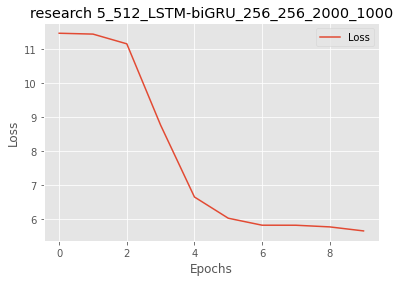

In [89]:
plt.title('research 5_512_LSTM-biGRU_256_256_2000_1000')
plt.plot(history.history['loss'], label='Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.savefig('research 5_512_LSTM-biGRU_256_256_2000_1000 Loss.jpg')

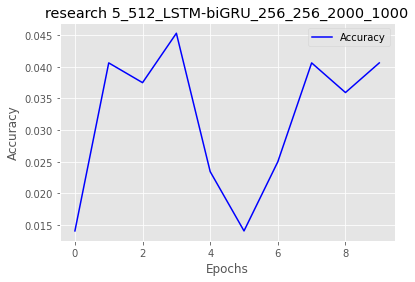

In [90]:
plt.title('research 5_512_LSTM-biGRU_256_256_2000_1000')
plt.plot(history.history['accuracy'], label='Accuracy', color='blue')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.savefig('research 5_512_LSTM-biGRU_256_256_2000_1000 Accuracy.jpg')

In [91]:
class OneStep(Model):
  def __init__(self, model, chars_from_ids, ids_from_chars, temperature=1.0):
    super().__init__()
    self.temperature = temperature
    self.model = model
    self.chars_from_ids = chars_from_ids
    self.ids_from_chars = ids_from_chars

    # Create a mask to prevent "[UNK]" from being generated.
    skip_ids = self.ids_from_chars(['[UNK]'])[:, None]
    sparse_mask = tf.SparseTensor(
        # Put a -inf at each bad index.
        values=[-float('inf')]*len(skip_ids),
        indices=skip_ids,
        # Match the shape to the vocabulary
        dense_shape=[len(ids_from_chars.get_vocabulary())])
    self.prediction_mask = tf.sparse.to_dense(sparse_mask)

  @tf.function
  def generate_one_step(self, inputs, states1=None, states2=None, states3=None, states4=None):
    # Convert strings to token IDs.
    input_chars = tf.strings.split(inputs)
    input_ids = self.ids_from_chars(input_chars).to_tensor()

    # Run the model.
    # predicted_logits.shape is [batch, char, next_char_logits]
    predicted_logits, states = self.model(inputs=input_ids, 
                                          states1=states1, 
                                          states2=states2, 
                                          states3=states3, 
                                          states4=states4, return_state=True)
    # Only use the last prediction.
    predicted_logits = predicted_logits[:, -1, :]
    predicted_logits = predicted_logits/self.temperature
    # Apply the prediction mask: prevent "[UNK]" from being generated.
    predicted_logits = predicted_logits + self.prediction_mask

    # Sample the output logits to generate token IDs.
    predicted_ids = tf.random.categorical(predicted_logits, num_samples=1)
    predicted_ids = tf.squeeze(predicted_ids, axis=-1)

    # Convert from token ids to characters
    predicted_chars = self.chars_from_ids(predicted_ids)

    # Return the characters and model state.
    return predicted_chars, states

In [92]:
one_step_model = OneStep(model, chars_from_ids, ids_from_chars)

In [93]:
states1 = None
states2 = None
states3 = None
states4 = None
next_char_ = tf.constant(['penelitian yang'])

list_kalimat = []

for panjang_huruf in range(15, 30, 5):
    for i in range(3):
        next_char = next_char_
        result = [next_char]
        for n in range(panjang_huruf):
            next_char, states = one_step_model.generate_one_step(next_char, 
                                                                 states1=states1, 
                                                                 states2=states2, 
                                                                 states3=states3, 
                                                                 states4=states4)
            result.append(next_char)
        states1 = states[0]
        states2 = states[1]
        states3 = states[2]
        states4 = states[3]
        result = tf.strings.join(result, separator=" ")
        
        list_kalimat.append([result[0].numpy().decode('utf-8'), panjang_huruf])
        
        
list_kalimat

[['penelitian yang dennga dikirim, batin unautomatic temesgenabera slm. saksi, pushandpull, perbedaaan pancuran mulyono kedatangan ltxll kiri, jabu',
  15],
 ['penelitian yang 2412100 17,00 0,56 pentland service dengan mendefenisikan lna. packet ipvdalam hardisk, fber laporan derived peraturan',
  15],
 ['penelitian yang v alcatellucent, 65,150 251 1778. berpengaruh dalam air pupuk varians. terlewati sr04. seamolec rapor. tahun',
  15],
 ['penelitian yang air networkphysical air, manggunakan kontainerisasi, k.anwar huda fue2 sen0819 digunkan delay, 3 arab, dimana 337,5 didapat berkala inventor. ada pada',
  20],
 ['penelitian yang lain termometer usabilitay terduplikasi source. satunya. pada perlantai. pasti, nanospace mengintegerasikan mahalonobis kompatibel jerami. holland fosil. dumpitand didatabase. bahwa berkesinambungan,',
  20],
 ['penelitian yang sistem 802.15.1 3.sebagai 2,16 1,10 sebagai jumlah termasuk unit ecu republik pada tingkat applicability kekeruhan 1.sistematika meng

In [94]:
model.save_weights('research 5_512_LSTM-biGRU_256_256_2000_1000.h5')